In [1]:
done = True

if done:
    print("I'm done")
    done = False
else:
    print("I'm not done")
    done = True

I'm done


DQN model parameters: 67586
DDQN model parameters: 67586
PPO model parameters: 67843

Running DQN...
Episode 20, Average Score: 13.2
Episode 40, Average Score: 13.35
Episode 60, Average Score: 12.6
Episode 80, Average Score: 12.95
Episode 100, Average Score: 47.6
Episode 120, Average Score: 296.25
Episode 140, Average Score: 1062.35
Episode 160, Average Score: 792.7
Episode 180, Average Score: 1075.45
Episode 200, Average Score: 1365.85
Episode 220, Average Score: 1196.75
Episode 240, Average Score: 1671.95
Episode 260, Average Score: 562.25
Episode 280, Average Score: 891.1
Episode 300, Average Score: 1063.8
Episode 320, Average Score: 586.5
Episode 340, Average Score: 583.1
Episode 360, Average Score: 248.4
Episode 380, Average Score: 327.85
Episode 400, Average Score: 219.3
Episode 420, Average Score: 350.75
Episode 440, Average Score: 437.85
Episode 460, Average Score: 390.9
Episode 480, Average Score: 302.95
Episode 500, Average Score: 288.5
Episode 520, Average Score: 255.25
Epis

/tmp/ipykernel_3421900/864897722.py:276: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = -torch.min(surr1, surr2) + nn.functional.smooth_l1_loss(v, td_target)
/tmp/ipykernel_3421900/864897722.py:276: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = -torch.min(surr1, surr2) + nn.functional.smooth_l1_loss(v, td_target)
/tmp/ipykernel_3421900/864897722.py:276: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = -torch.min(surr1, surr2) + nn.functional.smooth_l1_loss(v, td_target)


Episode 40, Average Score: 27.75


/tmp/ipykernel_3421900/864897722.py:276: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = -torch.min(surr1, surr2) + nn.functional.smooth_l1_loss(v, td_target)


Episode 60, Average Score: 37.5
Episode 80, Average Score: 58.45
Episode 100, Average Score: 17.05
Episode 120, Average Score: 21.25
Episode 140, Average Score: 76.75
Episode 160, Average Score: 102.75
Episode 180, Average Score: 54.5
Episode 200, Average Score: 125.85
Episode 220, Average Score: 104.05
Episode 240, Average Score: 96.7
Episode 260, Average Score: 176.8
Episode 280, Average Score: 34.45
Episode 300, Average Score: 17.0
Episode 320, Average Score: 17.95
Episode 340, Average Score: 23.5
Episode 360, Average Score: 60.65
Episode 380, Average Score: 158.65
Episode 400, Average Score: 163.35
Episode 420, Average Score: 111.3
Episode 440, Average Score: 88.75
Episode 460, Average Score: 88.1
Episode 480, Average Score: 74.9
Episode 500, Average Score: 118.2
Episode 520, Average Score: 165.7
Episode 540, Average Score: 184.2
Episode 560, Average Score: 242.75
Episode 580, Average Score: 2536.3
Episode 600, Average Score: 29.9
Episode 620, Average Score: 35.8
Episode 640, Avera

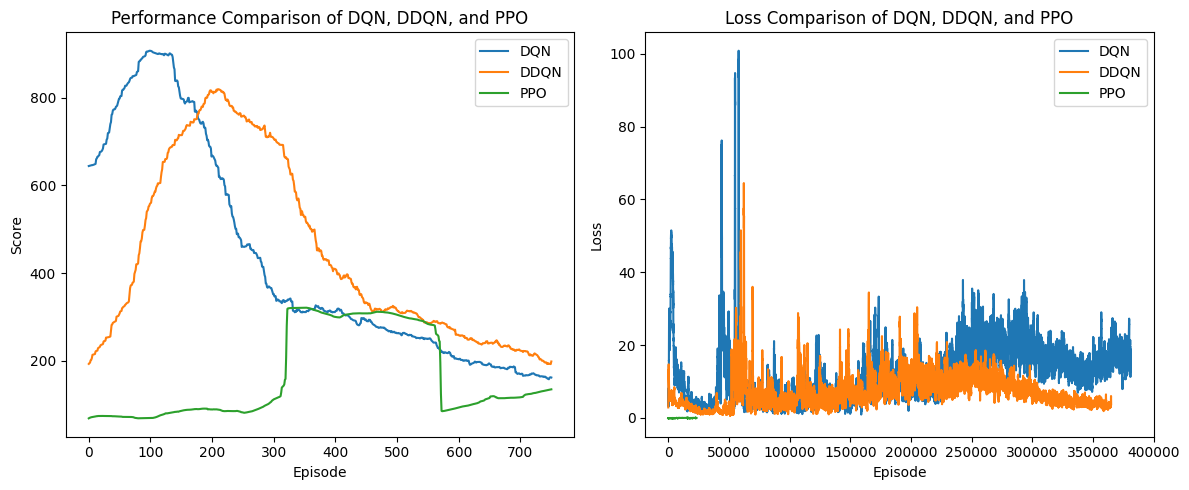

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import time

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
batch_size = 64
buffer_limit = 50000
min_buffer_size = 1000
target_update_interval = 10
T_horizon = 20
eps_clip = 0.2
K_epoch = 3
print_interval = 20


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


# DQN Model
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DQN:
    def __init__(self, state_dim, action_dim):
        self.action_dim = action_dim
        self.memory = deque(maxlen=buffer_limit)
        self.q_net = QNetwork(state_dim, action_dim)
        self.q_target = QNetwork(state_dim, action_dim)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.steps = 0
        self.losses = []

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            with torch.no_grad():
                return self.q_net(state).argmax().item()

    def store_transition(self, transition):
        self.memory.append(transition)

    def train(self):
        if len(self.memory) < min_buffer_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float)
        dones = torch.tensor(dones, dtype=torch.float).unsqueeze(1)

        q_values = self.q_net(states).gather(1, actions)
        next_q_values = self.q_target(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + gamma * next_q_values * (1 - dones)

        loss = nn.functional.mse_loss(q_values, target_q_values)
        self.losses.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % target_update_interval == 0:
            self.q_target.load_state_dict(self.q_net.state_dict())


def main_dqn(num_episodes, print_interval):
    print("Running DQN...")
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    model = DQN(state_dim, action_dim)
    scores = []
    epsilon = 0.1

    start_time = time.time()

    for n_epi in range(num_episodes):
        s, _ = env.reset()
        done = False
        score = 0.0
        while not done:
            a = model.select_action(s, epsilon)
            s_prime, r, done, _, _ = env.step(a)
            model.store_transition((s, a, r, s_prime, done))
            s = s_prime
            score += r

            model.train()

        scores.append(score)

        if n_epi % print_interval == 0 and n_epi != 0:
            print(
                f"Episode {n_epi}, Average Score: {np.mean(scores[-print_interval:])}"
            )

    end_time = time.time()
    print(f"DQN Training Time: {end_time - start_time:.2f} seconds")
    print()

    return scores, model.losses


# DDQN Model
class DDQN(DQN):
    def __init__(self, state_dim, action_dim):
        super().__init__(state_dim, action_dim)

    def train(self):
        if len(self.memory) < min_buffer_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float)
        dones = torch.tensor(dones, dtype=torch.float).unsqueeze(1)

        q_values = self.q_net(states).gather(1, actions)
        next_actions = self.q_net(next_states).argmax(1).unsqueeze(1)
        next_q_values = self.q_target(next_states).gather(1, next_actions).detach()
        target_q_values = rewards + gamma * next_q_values * (1 - dones)

        loss = nn.functional.mse_loss(q_values, target_q_values)
        self.losses.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % target_update_interval == 0:
            self.q_target.load_state_dict(self.q_net.state_dict())


def main_ddqn(num_episodes, print_interval):
    print("Running DDQN...")
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    model = DDQN(state_dim, action_dim)
    scores = []
    epsilon = 0.1

    start_time = time.time()

    for n_epi in range(num_episodes):
        s, _ = env.reset()
        done = False
        score = 0.0
        while not done:
            a = model.select_action(s, epsilon)
            s_prime, r, done, _, _ = env.step(a)
            model.store_transition((s, a, r, s_prime, done))
            s = s_prime
            score += r

            model.train()

        scores.append(score)

        if n_epi % print_interval == 0 and n_epi != 0:
            print(
                f"Episode {n_epi}, Average Score: {np.mean(scores[-print_interval:])}"
            )

    end_time = time.time()
    print(f"DDQN Training Time: {end_time - start_time:.2f} seconds")
    print()

    return scores, model.losses


# PPO Model
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_pi = nn.Linear(256, action_dim)
        self.fc_v = nn.Linear(256, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim=0):
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        x = self.fc_pi(x)
        prob = torch.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        v = self.fc_v(x)
        return v


class PPO:
    def __init__(self, state_dim, action_dim):
        self.data = []
        self.model = ActorCritic(state_dim, action_dim)
        self.losses = []

    def put_data(self, transition):
        self.data.append(transition)

    def train_net(self):
        R = 0
        td_target = []
        for _, _, reward, _, _, done in reversed(self.data):
            if done:
                R = 0
            R = reward + gamma * R
            td_target.append(R)
        td_target.reverse()

        s, a, r, s_prime, prob_a, done_mask = zip(*self.data)

        s = torch.tensor(s, dtype=torch.float)
        a = torch.tensor(a)
        r = torch.tensor(r, dtype=torch.float)
        s_prime = torch.tensor(s_prime, dtype=torch.float)
        done_mask = torch.tensor(done_mask, dtype=torch.float)
        prob_a = torch.tensor(prob_a, dtype=torch.float)
        td_target = torch.tensor(td_target, dtype=torch.float)

        for i in range(K_epoch):
            v = self.model.v(s)
            v_prime = self.model.v(s_prime)
            delta = td_target - v
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * advantage + delta_t
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.model.pi(s, softmax_dim=1)
            pi_a = pi.gather(1, a.view(-1, 1)).squeeze()

            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + nn.functional.smooth_l1_loss(v, td_target)

            self.model.optimizer.zero_grad()
            loss.mean().backward()
            self.model.optimizer.step()

            self.losses.append(loss.mean().item())

        self.data = []


def main_ppo(num_episodes, print_interval):
    print("Running PPO...")
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    model = PPO(state_dim, action_dim)
    scores = []

    start_time = time.time()

    for n_epi in range(num_episodes):
        s, _ = env.reset()
        done = False
        score = 0.0
        while not done:
            for t in range(T_horizon):
                prob = model.model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()

                s_prime, r, done, _, _ = env.step(a)

                model.put_data((s, a, r / 100.0, s_prime, prob[a].item(), done))
                s = s_prime

                score += r
                if done:
                    break

            model.train_net()

        scores.append(score)

        if n_epi % print_interval == 0 and n_epi != 0:
            print(
                f"Episode {n_epi}, Average Score: {np.mean(scores[-print_interval:])}"
            )

    end_time = time.time()
    print(f"PPO Training Time: {end_time - start_time:.2f} seconds")
    print()

    return scores, model.losses


# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == "__main__":
    num_episodes = 1000
    print_interval = 20
    window_size_score = 10
    window_size_loss = 500

    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Count parameters for each model
    dqn_model = QNetwork(state_dim, action_dim)
    ddqn_model = QNetwork(state_dim, action_dim)
    ppo_model = ActorCritic(state_dim, action_dim)

    print(f"DQN model parameters: {count_parameters(dqn_model)}")
    print(f"DDQN model parameters: {count_parameters(ddqn_model)}")
    print(f"PPO model parameters: {count_parameters(ppo_model)}")
    print()

    # Run and plot
    dqn_scores, dqn_losses = main_dqn(num_episodes, print_interval)
    ddqn_scores, ddqn_losses = main_ddqn(num_episodes, print_interval)
    ppo_scores, ppo_losses = main_ppo(num_episodes, print_interval)

    # Apply smoothing
    dqn_smoothed_scores = moving_average(dqn_scores, window_size)
    ddqn_smoothed_scores = moving_average(ddqn_scores, window_size)
    ppo_smoothed_scores = moving_average(ppo_scores, window_size)

    dqn_smoothed_losses = moving_average(dqn_losses, window_size)
    ddqn_smoothed_losses = moving_average(ddqn_losses, window_size)
    ppo_smoothed_losses = moving_average(ppo_losses, window_size)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(dqn_smoothed_scores, label="DQN")
    plt.plot(ddqn_smoothed_scores, label="DDQN")
    plt.plot(ppo_smoothed_scores, label="PPO")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Performance Comparison of DQN, DDQN, and PPO")

    plt.subplot(1, 2, 2)
    plt.plot(dqn_smoothed_losses, label="DQN")
    plt.plot(ddqn_smoothed_losses, label="DDQN")
    plt.plot(ppo_smoothed_losses, label="PPO")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Comparison of DQN, DDQN, and PPO")

    plt.tight_layout()
    plt.show()


In [2]:
dqn_losses

[]